## Entrenamiento RF sobre diversos datasets

### Librerias utilizadas + seed

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from scipy.io import arff
import os
from scipy.stats import lognorm
from scipy.stats import norm

SEED = 21415

### Cargar el dataset

In [ ]:
# Reemplazar con el PATH del dataset descargado
dataset_filepath = 'titanic_fare_test.arff'

# Para cargar el dataset
data = arff.loadarff(dataset_filepath) 
df = pd.DataFrame(data[0])

### Separación entre Test y Validation

In [ ]:
# Reemplazar con la columna a predecir
pred_col_name = 'Fare'

# Separacion en Train, Validation ('X' e 'y' para cada split)
train_df, validation_df = train_test_split(df, test_size=0.2, random_state=SEED)
y_train, y_valid = train_df[pred_col_name], validation_df[pred_col_name]
X_train, X_valid = train_df.drop(pred_col_name, axis=1), validation_df.drop(pred_col_name, axis=1)


# Aplicar get_dummies para variables categóricas
# X_train = pd.get_dummies(X_train)
# X_valid = pd.get_dummies(X_valid)

# Alinear columnas de X_train y X_valid para que tengan las mismas características
# X_train, X_valid = X_train.align(X_valid, join='left', axis=1, fill_value=0)

### Creación de modelo de RF

In [ ]:
rf_model = RandomForestRegressor(random_state=SEED)

### Entrenamiento

In [ ]:
rf_model.fit(X_train, y_train)

RandomForestRegressor(random_state=21415)

### Predicción en validación

In [ ]:
model_predictions = rf_model.predict(X_valid)

### Calcular métricas de accuracy

In [ ]:
mse = mean_squared_error(y_valid, model_predictions)
print(f"Mean Squared Error of the model: {mse:.4f}")

Mean Squared Error of the model: 1133.6675


### Graficar ambos histogramas con la curva que mejor los fittea

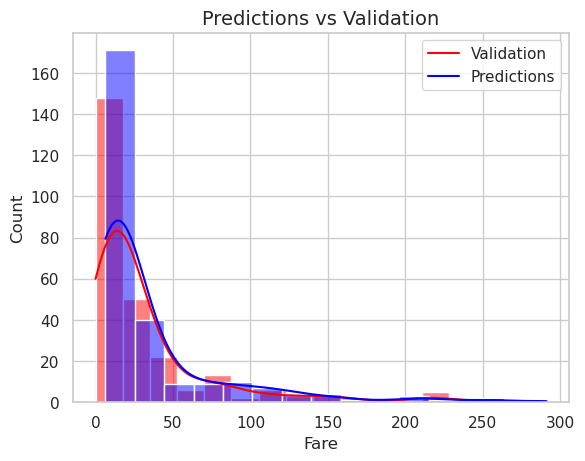

In [ ]:
sns.histplot(data=y_valid, bins=15, kde=True, color='red', label='y_valid')
sns.histplot(data=model_predictions, bins=15, kde=True, color='blue', label='model_predictions')

plt.title('Predictions vs Validation', fontsize=14)
plt.legend(['Validation', 'Predictions'])
plt.show()

### Comparar la curva que fittea con una Normal

In [ ]:
def plot_normal_fit(predictions, dataset_name):
    
    predictions = np.array(predictions)
    

    plt.figure(figsize=(10, 6))
    sns.histplot(predictions, bins=15, kde=True, color='red', label='model_predictions', stat='density')
    
    # Fitteamos una Normal
    mu, std = norm.fit(predictions)
    x = np.linspace(min(predictions), max(predictions), 1000)
    pdf_fitted = norm.pdf(x, mu, std)
    
    
    plt.plot(x, pdf_fitted, 'g-', lw=2, label='Fitted Normal')
    
    plt.title(f'Distribución de las predicciones vs Distribución Normal Fitteada')
    plt.legend()
    plt.savefig(f'graficos/{dataset_name}_distribution_norm.png', format='png', dpi=300, bbox_inches='tight')
    plt.show()
    
    
    return mu, std

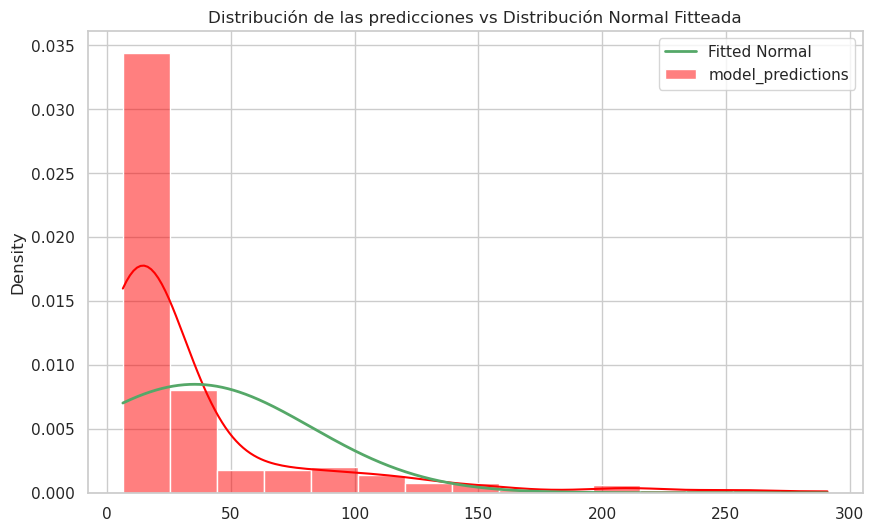

(35.34281791878778, 47.03321943239172)

In [ ]:
plot_normal_fit(model_predictions,'titanic')

### Comparar la curva que fittea con una Log-Normal

In [ ]:
def plot_log_normal_fit(predictions,dataset_name):

    predictions = np.array(predictions)
    
    plt.figure(figsize=(10, 6))
    sns.histplot(predictions, bins=15, kde=True, color='red', label='model_predictions', stat='density')

    # Solo valores positivos
    predictions = predictions[predictions > 0]

    # Fitteamos una log-normal
    shape, loc, scale = lognorm.fit(predictions, floc=0)
    x = np.linspace(min(predictions), max(predictions), 1000)
    pdf_fitted = lognorm.pdf(x, shape, loc, scale)
    

    plt.plot(x, pdf_fitted, 'b-', lw=2, label='Fitted Log-Normal')

    plt.title(f'Distribución de las predicciones vs Distribución Log-Normal Fitteada')
    plt.legend()
    plt.savefig(f'graficos/{dataset_name}_distribution_log.png', format='png', dpi=300, bbox_inches='tight')
    plt.show()
    
    
    return shape, loc, scale


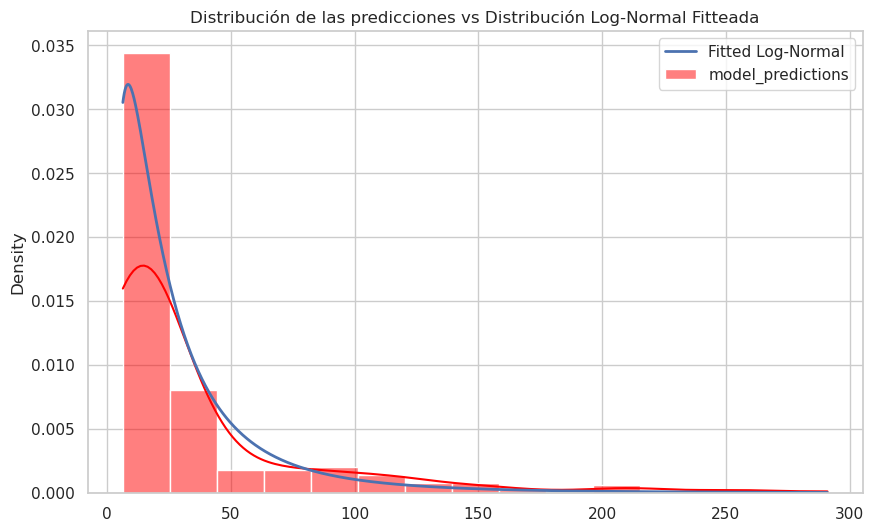

(0.943405694952939, 0, 20.6670688376924)

In [ ]:
plot_log_normal_fit(model_predictions, 'titanic')

### Grafico para comparar modelos en accuracy

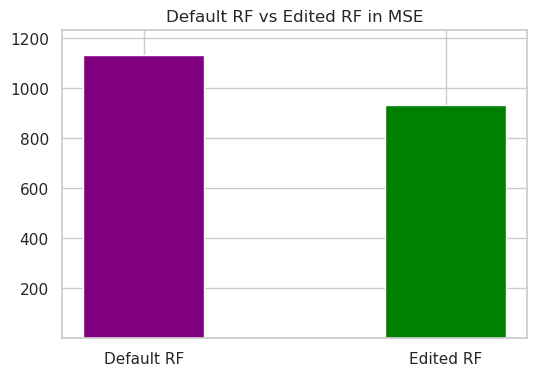

In [ ]:
default_rf_avg_distance = mse
edited_rf_avg_distance = mse - 200

plt.figure(figsize=(6, 4))
plt.bar(x=["Default RF", "Edited RF"], height=[default_rf_avg_distance, edited_rf_avg_distance], 
        color=['purple', 'green'], width=0.4)
plt.ylim(1, max(default_rf_avg_distance, edited_rf_avg_distance) + 100)
plt.title("Default RF vs Edited RF in MSE")

plt.show()

### Probemos mas datasets...

### Codigo para analizar distribución de las predicciones de arboles individuales

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
import pandas as pd
import os
from scipy.io import arff

SEED = 42

def process_dataset(dataset_filepath, pred_col_name):
    _, file_extension = os.path.splitext(dataset_filepath)

    # Cargar el dataset según la extensión
    if file_extension == '.arff':
        data = arff.loadarff(dataset_filepath)
        df = pd.DataFrame(data[0])

    elif file_extension == '.csv':
        df = pd.read_csv(dataset_filepath)

    else:
        print(f"Formato no soportado: {file_extension}")
        return None, None, None

    # Separar el dataset en Train y Validation
    train_df, validation_df = train_test_split(df, test_size=0.2, random_state=SEED)
    y_train, y_valid = train_df[pred_col_name], validation_df[pred_col_name]
    X_train, X_valid = train_df.drop(pred_col_name, axis=1), validation_df.drop(pred_col_name, axis=1)

    # Aplicar get_dummies para variables categóricas
    X_train = pd.get_dummies(X_train)
    X_valid = pd.get_dummies(X_valid)
    X_train, X_valid = X_train.align(X_valid, join='left', axis=1, fill_value=0)

    # Crear y entrenar el modelo de Random Forest
    rf_model = RandomForestRegressor(random_state=SEED)
    rf_model.fit(X_train, y_train)

    # Evaluar el modelo
    predictions = rf_model.predict(X_valid)
    mse = mean_squared_error(y_valid, predictions)

    # Convertir X_valid a un array para evitar la advertencia
    X_valid_array = X_valid.values

    # Obtener las predicciones individuales de cada árbol
    individual_tree_predictions = []
    for tree in rf_model.estimators_:
        individual_tree_predictions.append(tree.predict(X_valid_array))

    # Convertir las predicciones de los árboles a un DataFrame para un mejor análisis
    individual_tree_predictions_df = pd.DataFrame(individual_tree_predictions).T
    individual_tree_predictions_df.columns = [f'Tree_{i+1}' for i in range(len(rf_model.estimators_))]

    return df, mse, predictions, individual_tree_predictions_df


In [ ]:
# https://www.openml.org/search?type=data&status=active&id=41265 

dataset_filepath = 'titanic_fare_test.arff'  # Aquí se incluirían las rutas a los datasets
pred_col_name = 'Fare'  # Columna a predecir
dataset_titanic, mse_titanic, predictions_titanic, individual_predictions_df_titanic = process_dataset(dataset_filepath, pred_col_name)

In [ ]:
individual_predictions_df_titanic

,Tree_1,Tree_2,Tree_3,Tree_4,Tree_5,Tree_6,Tree_7,Tree_8,Tree_9,Tree_10,...,Tree_91,Tree_92,Tree_93,Tree_94,Tree_95,Tree_96,Tree_97,Tree_98,Tree_99,Tree_100
0,11.500000,26.000000,11.500000,11.500000,11.500000,11.500000,21.000000,11.500000,11.500000,26.000000,...,26.000000,11.500000,26.000000,26.000000,13.000000,11.500000,26.000000,11.500000,26.000000,11.500000
1,26.550000,34.525000,32.930000,34.525000,42.500000,42.500000,42.500000,26.550000,26.550000,42.500000,...,42.500000,42.500000,0.000000,42.500000,26.550000,31.866667,31.866667,34.525000,42.500000,26.550000
2,7.890100,8.182480,7.632400,7.411450,8.348600,7.926660,7.435982,7.522900,7.833969,8.225000,...,7.771714,7.755000,7.643262,8.039160,7.674756,7.471429,7.521517,7.547200,7.546289,7.630943
3,31.683300,134.500000,130.592700,79.200000,126.633350,79.200000,110.883300,27.720800,31.683300,100.322200,...,100.322200,31.683300,134.500000,31.000000,31.683300,55.441700,134.500000,221.779200,31.683300,55.441700
4,13.000000,12.525000,13.500000,12.525000,12.525000,13.000000,12.525000,13.000000,12.525000,13.000000,...,12.525000,12.525000,12.525000,12.525000,12.525000,12.525000,12.525000,13.000000,13.000000,12.525000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
257,7.785609,7.767713,7.811817,7.750000,7.802986,7.760714,7.784267,7.775600,7.788264,7.763542,...,7.783683,7.772021,7.803483,7.781250,7.816222,7.752490,7.750000,7.798340,7.761111,7.758336
258,7.250000,7.854200,7.250000,7.775000,7.425000,21.913340,7.250000,7.600000,7.250000,7.460000,...,7.512500,7.650000,7.600000,7.512500,7.495800,7.512500,7.512500,19.722233,7.650000,7.650000
259,26.000000,29.700000,26.000000,26.000000,26.000000,29.700000,55.441700,79.200000,26.000000,26.000000,...,29.700000,29.700000,77.177075,26.000000,30.500000,26.000000,34.452500,55.441700,29.700000,29.700000
260,10.295967,11.149908,9.073198,11.475896,9.422904,11.727136,8.364571,8.774992,11.649543,12.129935,...,11.188568,13.869944,9.714422,10.429297,9.392935,9.152602,9.741278,12.516153,9.265013,9.989170


In [ ]:
individual_predictions_df_titanic.iloc[3]

Tree_1       31.68330
Tree_2      134.50000
Tree_3      130.59270
Tree_4       79.20000
Tree_5      126.63335
              ...    
Tree_96      55.44170
Tree_97     134.50000
Tree_98     221.77920
Tree_99      31.68330
Tree_100     55.44170
Name: 3, Length: 100, dtype: float64

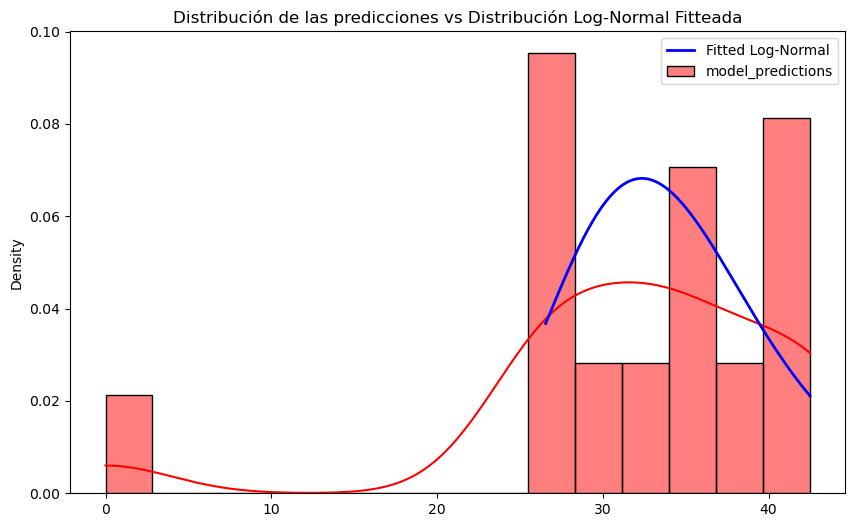

(0.17794753117157153, 0, 33.39705023846059)

In [ ]:
plot_log_normal_fit(individual_predictions_df_titanic.iloc[1], 'titanic')

### Codigo viejo

In [ ]:
def process_dataset(dataset_filepath, pred_col_name):

    _, file_extension = os.path.splitext(dataset_filepath)

    # Cargar el dataset según la extensión
    if file_extension == '.arff':
        data = arff.loadarff(dataset_filepath)
        df = pd.DataFrame(data[0])

    elif file_extension == '.csv':
        df = pd.read_csv(dataset_filepath)

    else:
        print(f"Formato no soportado: {file_extension}")
        return None, None, None

    # Separar el dataset en Train y Validation
    train_df, validation_df = train_test_split(df, test_size=0.2, random_state=SEED)
    y_train, y_valid = train_df[pred_col_name], validation_df[pred_col_name]
    X_train, X_valid = train_df.drop(pred_col_name, axis=1), validation_df.drop(pred_col_name, axis=1)

    # Aplicar get_dummies para variables categóricas -> lo agregue para poder porbar el dataset medico
    X_train = pd.get_dummies(X_train)
    X_valid = pd.get_dummies(X_valid)
    X_train, X_valid = X_train.align(X_valid, join='left', axis=1, fill_value=0) 

    # Crear y entrenar el modelo de Random Forest
    rf_model = RandomForestRegressor(random_state=SEED)
    rf_model.fit(X_train, y_train)

    # Evaluar el modelo
    predictions = rf_model.predict(X_valid)
    mse = mean_squared_error(y_valid, predictions)

    
    return df, mse, predictions

#### Dataset Titanic Fare

In [ ]:
# https://www.openml.org/search?type=data&status=active&id=41265 

dataset_filepath = 'titanic_fare_test.arff'  # Aquí se incluirían las rutas a los datasets
pred_col_name = 'Fare'  # Columna a predecir
dataset_titanic, mse_titanic, predictions_titanic = process_dataset(dataset_filepath, pred_col_name)

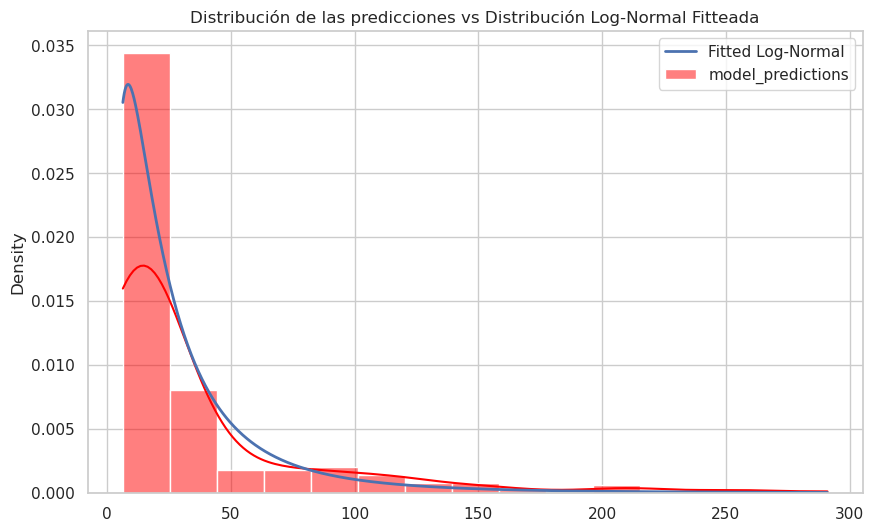

(0.943405694952939, 0, 20.6670688376924)

In [ ]:
plot_log_normal_fit(predictions_titanic, 'titanic')

#### Dataset boston_housing

In [ ]:
# https://www.openml.org/search?type=data&status=active&id=531

dataset_filepath = 'boston_housing.arff'  # Aquí se incluirían las rutas a los datasets
pred_col_name = 'MEDV'  # Columna a predecir
dataset_boston, mse_boston, predictions_boston = process_dataset(dataset_filepath, pred_col_name)

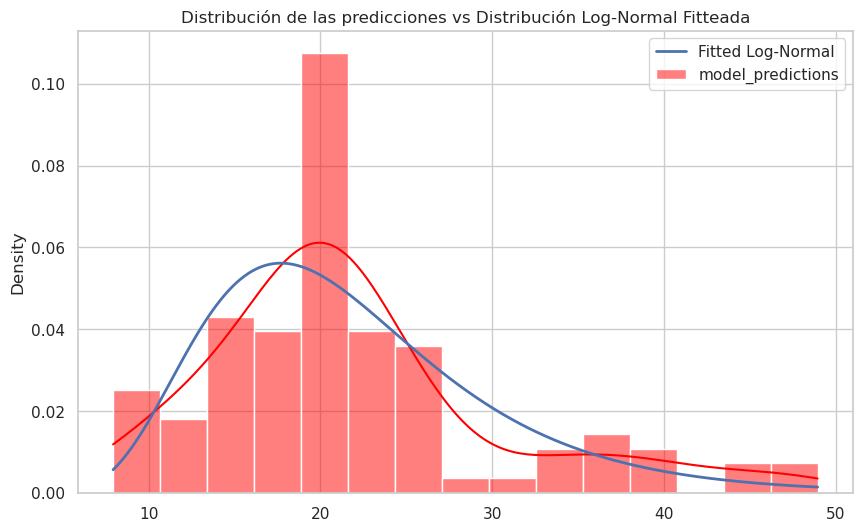

(0.3743068067694871, 0, 20.36061357025381)

In [ ]:
plot_log_normal_fit(predictions_boston, 'boston_housing')

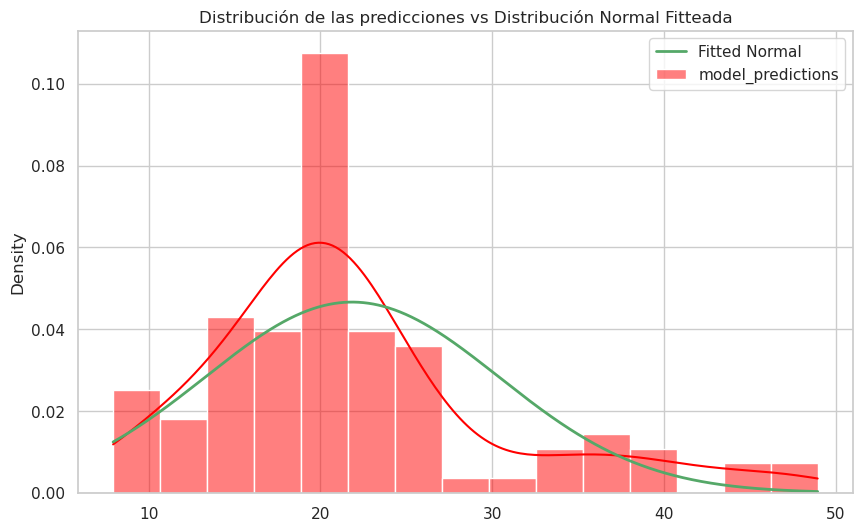

(21.846382352941173, 8.555434813263576)

In [ ]:
plot_normal_fit(predictions_boston, 'boston_housing')

#### Dataset Medical Costs

In [ ]:
# https://www.kaggle.com/datasets/satyajeetrai/medical-cost

dataset_filepath = 'medical_costs.csv'  # Aquí se incluirían las rutas a los datasets
pred_col_name = 'medical charges'  # Columna a predecir
dataset_med, mse_med, predictions_med = process_dataset(dataset_filepath, pred_col_name)

In [ ]:
print(mse_med)

23116784.491225


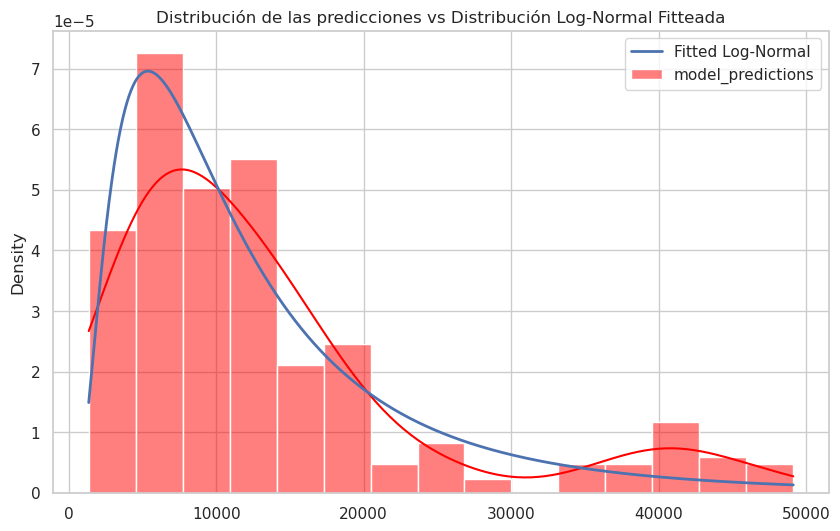

(0.7845633638926357, 0, 9939.098326414636)

In [ ]:
plot_log_normal_fit(predictions_med, 'medical_costs')

In [ ]:
# https://www.kaggle.com/datasets/jacopoferretti/parents-heights-vs-children-heights-galton-data

dataset_filepath = 'Height.csv'  # Aquí se incluirían las rutas a los datasets
pred_col_name = 'childHeight'  # Columna a predecir
dataset_height, mse_height, predictions_height = process_dataset(dataset_filepath, pred_col_name)

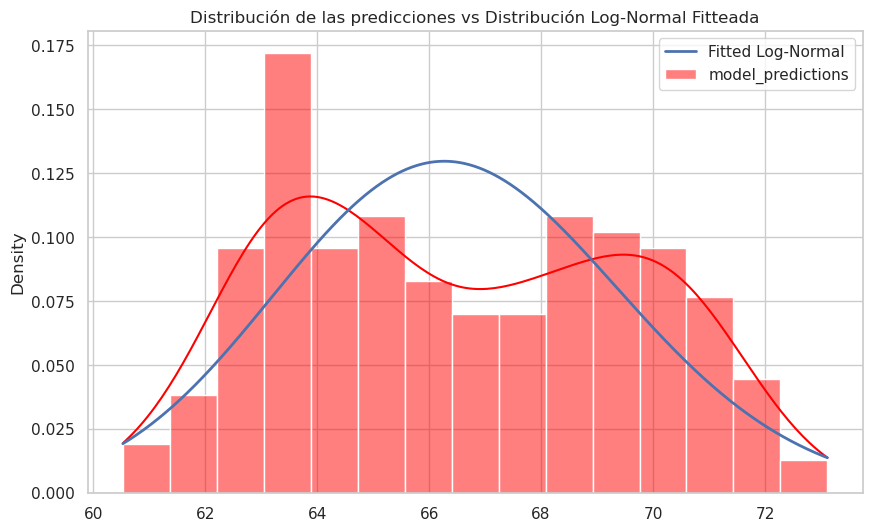

(0.04636189304004441, 0, 66.41352153808134)

In [ ]:
plot_log_normal_fit(predictions_height, 'height')

In [ ]:
# https://www.openml.org/search?type=data&status=active&sort=runs&qualities.NumberOfClasses=lte_1&id=553

dataset_filepath = 'kidney.arff'  # Aquí se incluirían las rutas a los datasets
pred_col_name = 'frailty'  # Columna a predecir
dataset_kidney, mse_kidney, predictions_kidney = process_dataset(dataset_filepath, pred_col_name)

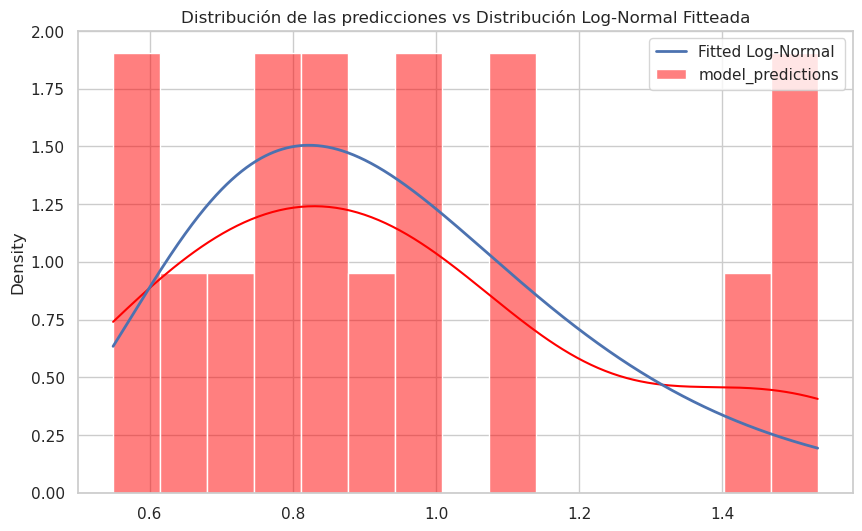

(0.30742116708805783, 0, 0.9039013782100702)

In [ ]:
plot_log_normal_fit(predictions_kidney, 'kidney')

In [ ]:
# https://www.openml.org/search?type=data&sort=runs&status=active&qualities.NumberOfClasses=lte_1&id=287

dataset_filepath = 'wine_quality.arff'  # Aquí se incluirían las rutas a los datasets
pred_col_name = 'quality'  # Columna a predecir
dataset_wine, mse_wine, predictions_wine = process_dataset(dataset_filepath, pred_col_name)

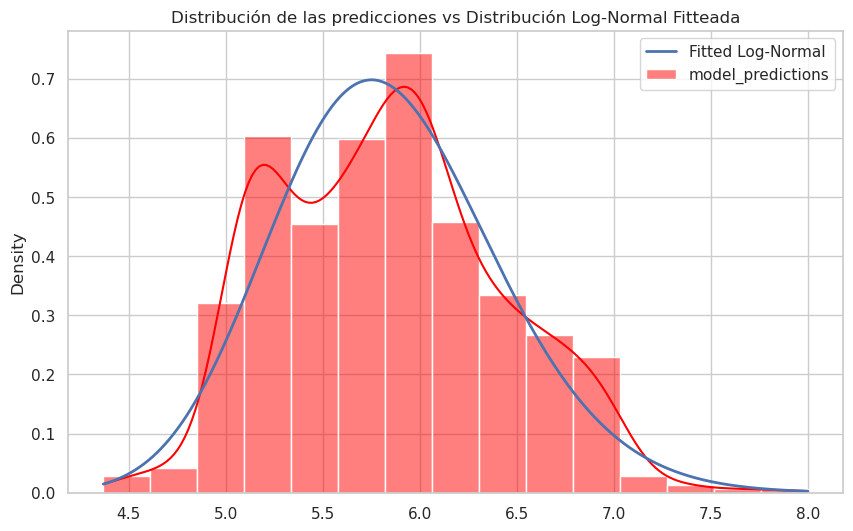

(0.09886488583110367, 0, 5.808279189060122)

In [ ]:
plot_log_normal_fit(predictions_wine, 'wine_quality')

In [ ]:
# https://www.openml.org/search?type=data&status=active&sort=runs&qualities.NumberOfClasses=lte_1&id=218 

dataset_filepath = 'house_8L.arff'  # Aquí se incluirían las rutas a los datasets
pred_col_name = 'price'  # Columna a predecir
dataset_house, mse_house, predictions_house = process_dataset(dataset_filepath, pred_col_name)

In [ ]:
print(mse_house)

747359851.4928204


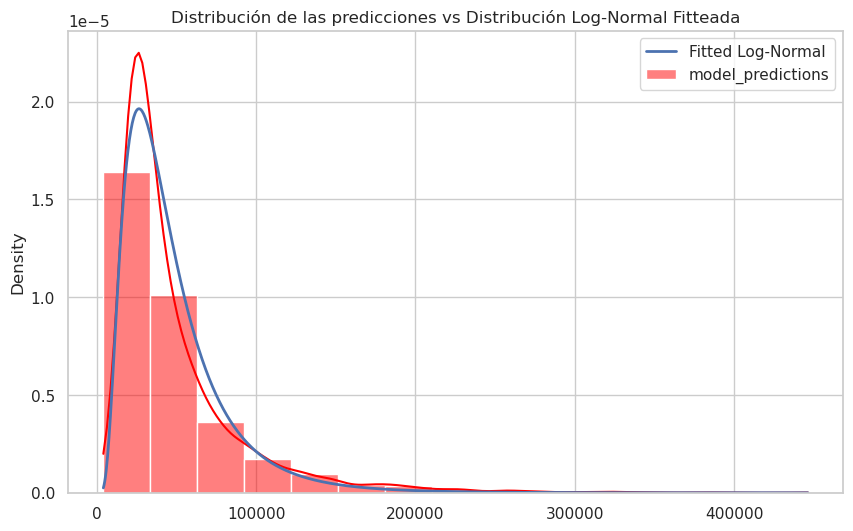

(0.6288857185274157, 0, 39363.738140444766)

In [ ]:
plot_log_normal_fit(predictions_house, 'house_8L')

In [ ]:
# https://www.kaggle.com/datasets/viveksharmar/flight-price-data 

dataset_filepath = 'flight_price.csv'  # Aquí se incluirían las rutas a los datasets
pred_col_name = 'Price'  # Columna a predecir
dataset_flight, mse_flight, predictions_flight = process_dataset(dataset_filepath, pred_col_name)

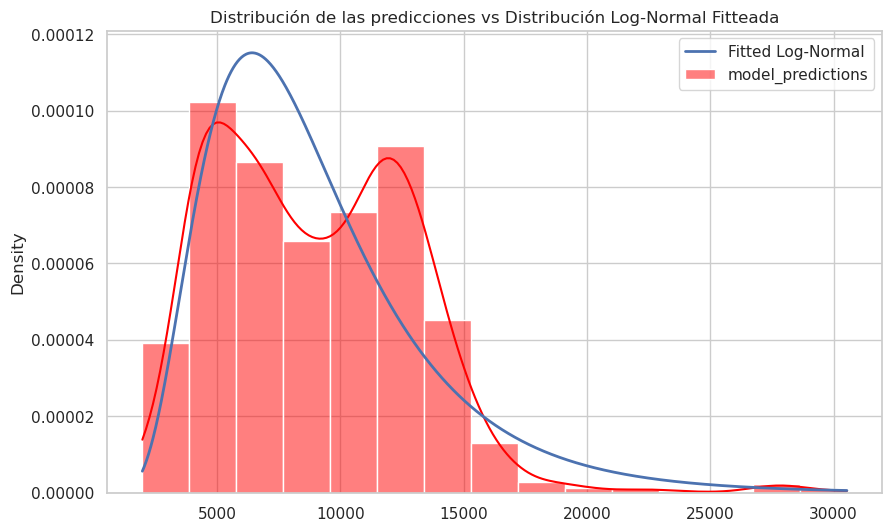

(0.48083514395488136, 0, 8091.380920395436)

In [ ]:
plot_log_normal_fit(predictions_flight, 'flight_fare')

In [ ]:
# https://www.kaggle.com/datasets/rabieelkharoua/predict-survival-of-patients-with-heart-failure 

dataset_filepath = 'heart_failure.csv'  # Aquí se incluirían las rutas a los datasets
pred_col_name = 'DEATH_EVENT'  # Columna a predecir
dataset_heart, mse_heart, predictions_heart = process_dataset(dataset_filepath, pred_col_name)

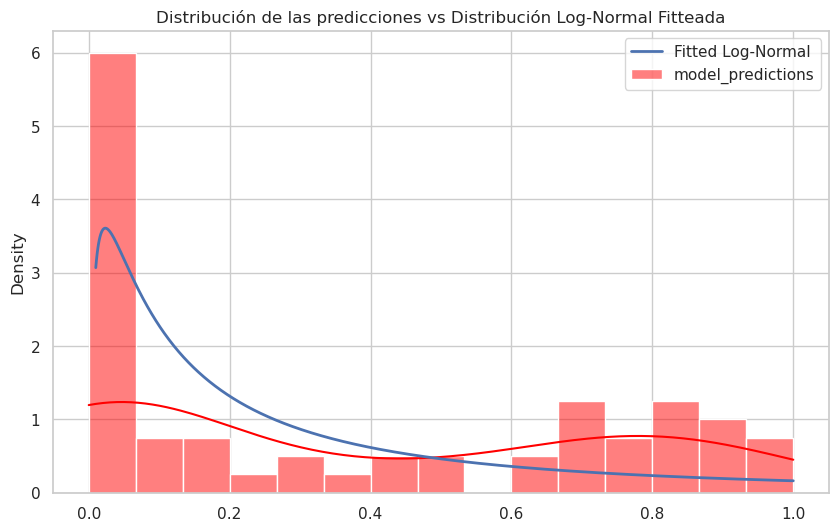

(1.507145433957909, 0, 0.22837421141435504)

In [ ]:
plot_log_normal_fit(predictions_heart, 'heart_failure')


In [ ]:
# https://www.kaggle.com/datasets/yasserh/student-marks-dataset

dataset_filepath = 'student_marks.csv'  # Aquí se incluirían las rutas a los datasets
pred_col_name = 'Marks'  # Columna a predecir
dataset_marks, mse_marks, predictions_marks = process_dataset(dataset_filepath, pred_col_name)

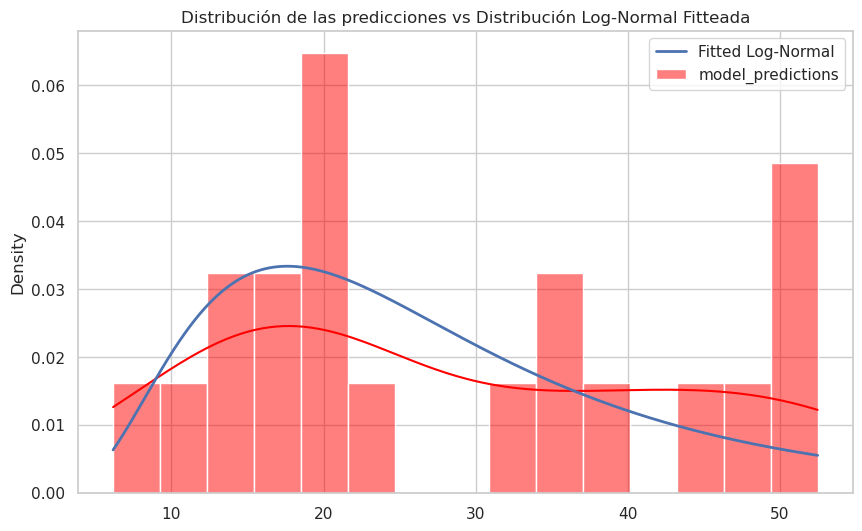

(0.5749646233675105, 0, 24.52927250148839)

In [ ]:
plot_log_normal_fit(predictions_marks, 'student_marks')

In [ ]:
# https://www.kaggle.com/datasets/ultimus/football-wages-prediction

dataset_filepath = 'salary_football.csv'  # Aquí se incluirían las rutas a los datasets
pred_col_name = 'Wage'  # Columna a predecir
dataset_salary, mse_salary, predictions_salary = process_dataset(dataset_filepath, pred_col_name)

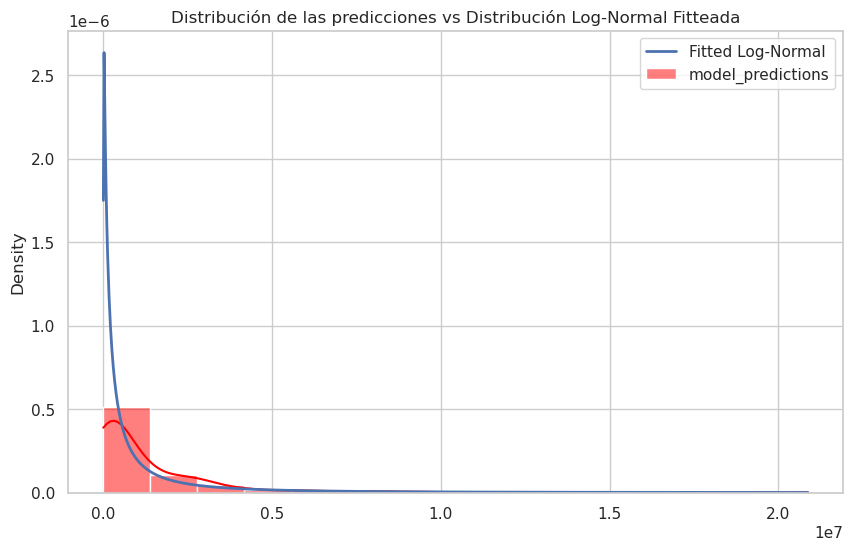

(1.7592792795772372, 0, 398591.7896088515)

In [ ]:
plot_log_normal_fit(predictions_salary, 'salary_football')

In [ ]:
# https://www.kaggle.com/datasets/nimapourmoradi/abalones-age

dataset_filepath = 'abalone.csv'  # Aquí se incluirían las rutas a los datasets
pred_col_name = 'Age'  # Columna a predecir
dataset_abalone, mse_abalone, predictions_abalone = process_dataset(dataset_filepath, pred_col_name)

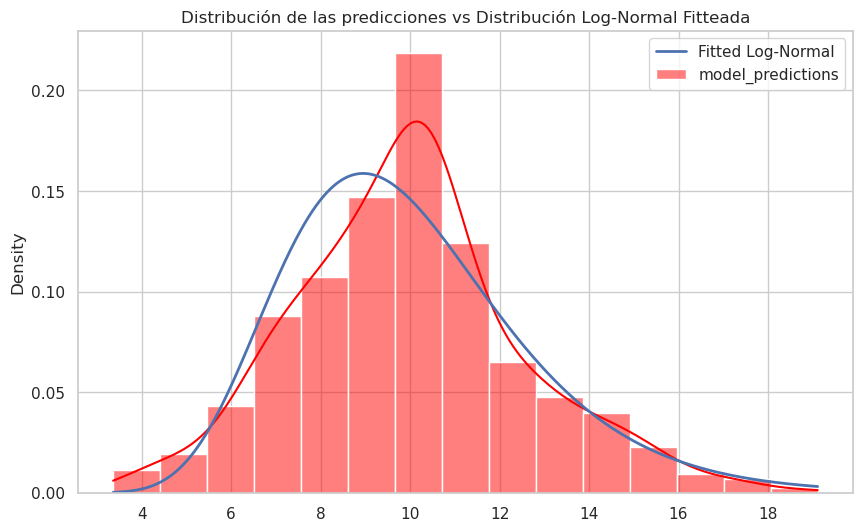

(0.27066753541133587, 0, 9.629987215127622)

In [ ]:
plot_log_normal_fit(predictions_abalone, 'abalone')

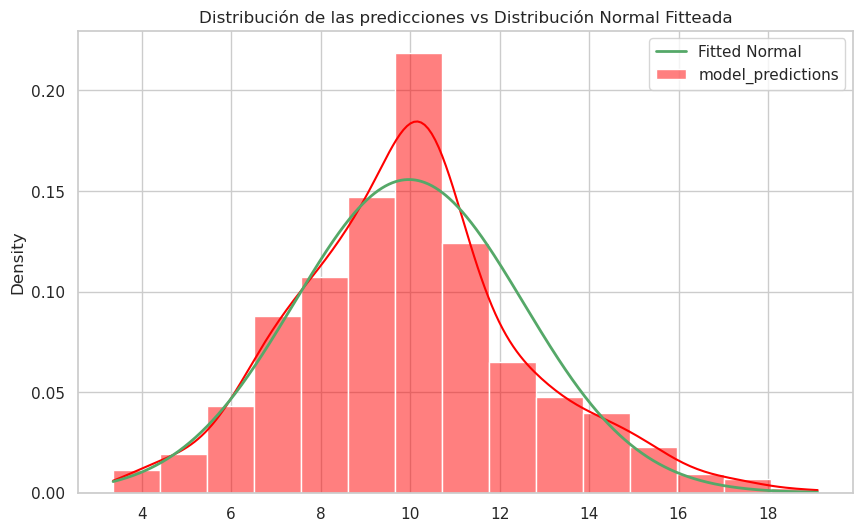

(9.9713995215311, 2.5618617684733347)

In [ ]:
plot_normal_fit(predictions_abalone, 'abalone')

In [ ]:
# https://www.openml.org/search?type=data&status=active&id=46292 -> paper breimann

dataset_filepath = 'servo.arff'  # Aquí se incluirían las rutas a los datasets
pred_col_name = '4'  #Columna a predecir
dataset_servo, mse_servo, predictions_servo = process_dataset(dataset_filepath, pred_col_name)

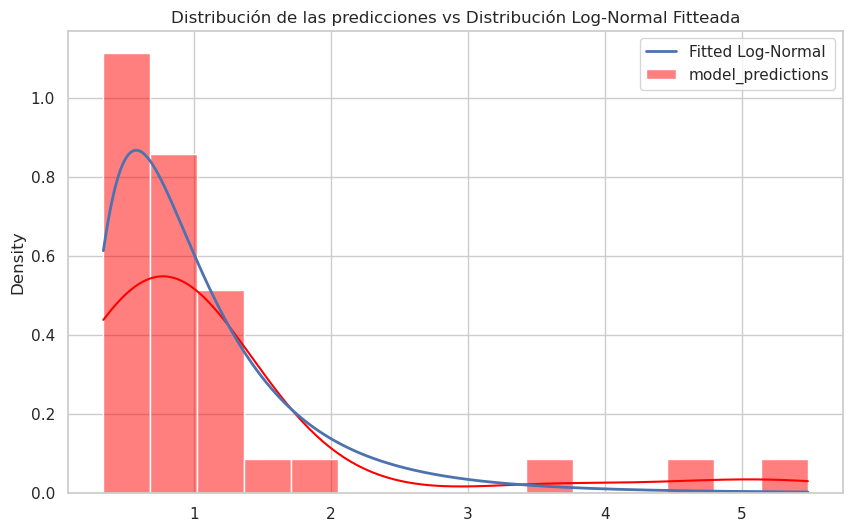

(0.6489185512392068, 0, 0.8751153273389292)

In [ ]:
plot_log_normal_fit(predictions_servo, 'servo')